# Load stuff

In [9]:
!pip install deep_translator
!pip install langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=057103e82e3e23b62240e8274ac1f5a389bf0d9cc79c3f6c406ac7c294bca9a5
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')
from scipy.sparse import csr_matrix
import scipy.sparse as sps
import matplotlib.pyplot as plt
!pip install leidenalg # this is the Louvain version we use!!!!
import leidenalg
import igraph as ig
import pickle
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.cm
!pip install umap-learn
import umap
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


In [2]:
!pip install bertopic
from bertopic import BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [3]:
class CleanText:
    # in the default mode we leave aside "PRON", they appear too many times
    def __init__(self, text, POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB"]):
        # capture execution time
        tic = time.time()
        # store original text
        self.text = list(text)
        # superficially clean it
        sup_clean = [self._superficial_cleaning(i) for i in self.text]
        # store deep cleaning of text
        self.text_clean = [self._deep_cleaning(i,POS_KEEP) for i in sup_clean]
        # store deep cleaning of POS
        self.pos_clean = [self._deep_cleaning_pos(i,POS_KEEP) for i in sup_clean]
        # capture execution time
        print(f'Cleaning text: execution time {time.time()-tic} [s]')

    def _superficial_cleaning(self, selftext):
        # Remove any HTML tag
        soup = BeautifulSoup(selftext, "html.parser")
        outtext = soup.get_text(separator=" ")
        # Remove any text inside square brackets
        outtext = re.sub(r'\[.*?\]', '', outtext)
        # Remove any website links
        outtext = re.sub(r'http\S+', '', outtext)
        outtext = re.sub(r'www.\S+', '', outtext)
        outtext = outtext.replace('. com', '.com')
        # Remove '&amp;#x200B;\n\'
        outtext = re.sub(r'&amp;#x200B;\n\\', ' ', outtext)
        outtext = re.sub(r'‚Äú', ' ', outtext)
        outtext = re.sub(r'‚Äô', "’", outtext)
        # Remove double spaces, newlines, tabs, and combinations
        outtext = re.sub(r' +', ' ', outtext)
        outtext = re.sub(r'\s{2,}', ' ', outtext)
        outtext = re.sub(r'&gt;', ' ', outtext)
        outtext = outtext.replace('-', ' ')
        outtext = outtext.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
        # Reduce repetition to two characters for alphabets and to
        # one character for punctuations
        Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
        Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
        outtext = Pattern_alpha.sub(r"\1\1", outtext)
        outtext = Pattern_Punct.sub(r'\1', outtext)
        outtext = re.sub(' {2,}',' ', outtext)
        # Remove extra whitespaces from the text
        pattern = re.compile(r'\s+')
        Without_whitespace = re.sub(pattern, ' ', outtext)
        outtext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        return outtext

    def _deep_cleaning(self, selftext,POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = ' '.join([token.lemma_ for token in nlp(selftext) if token.pos_ in POS_KEEP])
        return outtext

    def _deep_cleaning_pos(self, selftext,POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = [' '.join([token.lemma_,token.pos_]) for token in nlp(selftext) if token.pos_ in POS_KEEP]
        return outtext

In [4]:
def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y

def nmi_fn(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

def modularity_fn(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def ncut_fn(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def pagerank_fn(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

def _infomap_fn(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank_fn(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = pagerank_fn(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T
    return r

def infomap_fn(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = (C.T).dot(sps.diags(r.toarray().flatten()))
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = ((C[:,i].transpose()).dot(M)).dot(z[i].transpose())
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = _infomap_fn(q)
    for i in range(z.shape[0]):
      y += _infomap_fn(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/_infomap_fn(pd))-1
    return y

def _hlstr(string: str , color: str = 'white'):
    # return f"<mark style=background-color:{color}>{string} </mark>"
    return f"<span style=\"color:{color}\">{string} </span>"

def _colorize(attrs: np.ndarray, cmap: str = 'PiYG'):
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.colormaps.get_cmap(cmap)
    return list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))

def _display_html(tokens, attrs, co=1):
    return HTML("".join(list(map(_hlstr, tokens, _colorize(co*attrs)))))

def get_words_html(vec,wor,N):
    ind = np.argsort(-vec)
    wor = wor[ind[:N]]
    vec = vec[ind[:N]]
    vec = vec/vec[0]
    for j in range(len(wor)):
        wor[j] = str(nlp(str(wor[j]))[0].lemma_)
    return _display_html(wor,vec).data

In [5]:
class TopicDetection:
    ### builds an occurrence matrix for words ###
    def __init__(self, ct_class=[], n_min=2, n_max=1e10):
      if ct_class:
        # capture execution time
        tic = time.time()
        # collection of words
        self.words = np.unique([item for sublist in ct_class.pos_clean for item in sublist])
        # words dictionary
        words_dict = dict(zip(self.words,range(len(self.words))))
        # occurrence matrix for words
        self.Mwd = csr_matrix((len(self.words), len(ct_class.text)), dtype = np.int8).toarray()
        for i in range(len(ct_class.text)):
            for j in ct_class.pos_clean[i]:
                self.Mwd[words_dict[j],i] += 1
        # documents list
        self.documents = np.array(range(len(ct_class.text)))
        # remove words that are used once or twice
        select = ((np.sum(self.Mwd,axis=1)>=n_min)&(np.sum(self.Mwd,axis=1)<n_max))
        print('removing words...')
        with np.printoptions(threshold=np.inf):
          print(self.words[(np.sum(self.Mwd,axis=1)>=n_max)])
        self.Mwd = self.Mwd[select,:]
        self.words = self.words[select]
        # remove documents that do not contain words
        select = (np.sum(self.Mwd,axis=0)>0)
        self.Mwd = csr_matrix(self.Mwd[:,select])
        self.documents = self.documents[select]
        # capture execution time
        print(f'Occurrence matrix: execution time {time.time()-tic} [s]')

    # plots words occurrencies
    def plot_word_occurrence(self):
        plt.figure(figsize=(4, 3))
        plt.semilogy(-np.sort(-np.asarray(np.sum(td1.Mwd,axis=1)).reshape(-1)))
        plt.grid(True)
        plt.xlabel('word id')
        plt.ylabel('# of occurrences')
        plt.title("words occurrencies")

    # plots degree distributions
    def plot_degree_distributions(self,quale='words'):
        if quale=='words':
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=1))) # words degrees
        else:
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=0))) # documents degrees
        # degree distribution
        k = np.unique(dw)
        pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
        pk = pk/pk.sum()
        Pk = 1-np.cumsum(pk)
        # plot
        fig = plt.figure(figsize=(4, 3))
        plt.loglog(k,pk,'o')
        if quale=='words':
            plt.title("degree distribution for words")
        else:
            plt.title("degree distribution for documents")
        plt.xlabel("k")
        plt.ylabel("pk")
        plt.grid(True)
        plt.show()

    # build probability matrices
    def probability_matrices(self, equalik = True, tform = False):
        # capture execution time
        tic = time.time()
        if equalik: # documents equally likely
            self.Pwd = self.Mwd/self.Mwd.sum(axis=0).flatten()/self.Mwd.shape[1]
        else: # documents proportional to their length
            self.Pwd = self.Mwd/self.Mwd.sum()
        # TF-IDF format
        if (tform):
            iw = -logg(np.sum(self.Mwd>0,axis=1).flatten()/self.Mwd.shape[1])
            self.Pwd = sps.diags(np.array(iw)[0]).dot(self.Pwd) # TF-IDF form
            self.Pwd = self.Pwd/self.Pwd.sum() # normalize, treat it as Pwd
        # words and document matrices
        self.pd = self.Pwd.sum(axis=0).flatten()
        self.Pww = (self.Pwd/self.pd).dot(self.Pwd.T)
        self.pw = self.Pwd.sum(axis=1).flatten()
        self.Pdd = (self.Pwd.T/self.pw).dot(self.Pwd)
        # # joint words and document matrix - documents first
        # self.Paa = sps.hstack((sps.csr_matrix((self.Pwd.shape[1],self.Pwd.shape[1])),self.Pwd.T))
        # self.Paa = sps.vstack((self.Paa,sps.hstack((self.Pwd,sps.csr_matrix((self.Pwd.shape[0],self.Pwd.shape[0]))))))
        # self.Paa = self.Paa/2.0
        # ranking vector for Infomap
        self.rd = infomap_rank_fn(self.Pdd)
        # capture execution time
        print(f'Probability matrices: execution time {time.time()-tic} [s]')

    # run topic detection using Louvain
    def topic_detection_louvain(self):
        # capture execution time
        tic = time.time()

        # build a graph based on Pdd as adjacency matrix
        A = sps.csr_matrix(self.Pdd)
        G = ig.Graph.Adjacency((A > 0).toarray().tolist())
        G.es['weight'] = np.array(A[A.nonzero()])[0]
        # run Louvain on the graph to get a partition
        self.topics = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition,
                                        weights='weight')
        # map the partition into a community assignment matrix C
        self.C = self._partition_to_C()
        self.topics = [np.argmax(i) for i in self.C] # turn C into a vector!
        # updates topic matrices
        self.Pwc = self.Pwd.dot(self.C) # joint word + class probability
        self.Pcc = ((self.C.T).dot(self.Pdd)).dot(self.C) # joint class + class probability
        self.pc = self.Pcc.sum(axis=0)

        # capture execution time
        ext = time.time()-tic
        print(f'Louvain topic detection: execution time {ext} [s]')
        return ext

    # function to map the partition into a community assignment matrix C
    # where rows represent documents, and columns represent topics
    def _partition_to_C(self):
      C = sps.csr_matrix((self.Pdd.shape[0],len(self.topics)))
      for i in range(len(self.topics)):
        C[np.array(self.topics[i]),i] = 1
      return C

    # display clustering metrics
    def clustering_metrics(self, ext=np.inf):
        NMI = nmi_fn(self.Pwc)
        Q = modularity_fn(self.Pcc)
        Ncut = ncut_fn(self.Pcc)
        Infomap = infomap_fn(self.C,self.Pdd,self.rd)
        if (self.pc.shape[1]==1):
            com = 0
        else:
            com = _infomap_fn(self.pc)/np.log(self.pc.shape[1])
        if ext==np.inf:
          self.stats = {'topics': self.C.shape[1], 'com': com,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}
        else:
          self.stats = {'topics': self.C.shape[1], 'com': com, 'time': ext,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}

    # display clusters
    def display_clusters(self):
        # ordered cluster matrix
        pos = np.argsort(np.array([np.argmax(i) for i in self.C]))
        C = sps.csr_matrix(self.C.copy()).astype(np.float32)
        C = C[pos,]
        M = C*(C.T) # binary matrix with ones inside the communities
        # plot
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
        ax[0].plot(np.array(self.C.sum(axis=0))[0]/self.C.sum(),'o')
        ax[0].set_title('clusters dimensions')
        ax[0].grid(True)
        ax[1].imshow(M.toarray(), cmap='viridis')
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].set_title('clusters patterns')

    # display keywords
    def display_keywords(self, text, N=15):
      # build HTML array according to the weights in Pwc
      x = []
      for i in range(self.Pwc.shape[1]):
        x.append([get_words_html(self.Pwc.T[i].toarray()[0],self.words,N)])
      # build HTML array according to TF-IDF weigts in BERTopic
      topic_model = BERTopic() # prepare a BERTopic instance
      topic_model.fit(text)
      topic_model.update_topics(text, topics=self.topics, top_n_words=N)
      bx = [] #
      for k in range(self.C.shape[1]):
        wor = np.array([i for (i,j) in topic_model.get_topic(k)])
        vec = np.array([j for (i,j) in topic_model.get_topic(k)])
        bx.append([get_words_html(vec,wor,N)])
      # join them together and add titles
      c = np.concatenate(([[f'{i}'] for i in range(self.C.shape[1])],
                          [[f'{int(i)}'] for i in np.array(self.C.sum(axis=0))[0]],
                          np.array(x),np.array(bx)), axis=1)
      c = np.concatenate(([['Topic','#docs','Probability matrices keywords',
                                    'BERTopic keywords']],c))
      # map into HTML table and print
      out = '<table><col><col><col width=\"250\"><col width=\"250\">'
      out = out + ''
      for sublist in c:
          out = out + ' <tr><td style=\"padding:1px 8px;\" valign=\"top\">'
          out = out + ' </td><td style=\"padding:1px 8px;\" valign=\"top\">'.join(sublist)
          out = out + ' </td></tr>'
      out = out + ' </table>'
      display(HTML(out))

    # export data
    def pickle_export(self, filename):
        out_data = {
            'words': self.words,
            'documents': self.documents,
            'Mwd': self.Mwd,
            'Pwd': self.Pwd,
            'Pww': self.Pww,
            'Pdd': self.Pdd,
            'pd': self.pd,
            'pw': self.pw,
            'rd': self.rd,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'C': self.C,
            'topics': self.topics,
            'stats': self.stats
        }
        with open(filename, 'wb') as f:
            pickle.dump(out_data, f)

    # import data
    def pickle_import(self, filename):
        with open(filename, 'rb') as f:
            in_data = pickle.load(f)
        self.words = in_data['words']
        self.documents = in_data['documents']
        self.Mwd = in_data['Mwd']
        self.Pwd = in_data['Pwd']
        self.Pww = in_data['Pww']
        self.Pdd = in_data['Pdd']
        self.pd = in_data['pd']
        self.pw = in_data['pw']
        self.rd = in_data['rd']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.C = in_data['C']
        self.topics = in_data['topics']
        self.stats = in_data['stats']



# Load and clean data

In [7]:
# load dataframe
df = pd.read_csv("AfterMilton (3).csv")

"""
# cut df to wanted length
df['create_time'] = pd.to_datetime(df['create_time'])

# Define start and end date
start_date = '2024-09-01'
end_date = '2024-10-01'

# Filter the DataFrame for the date range
df_filtered = df[(df['create_time'] >= start_date) & (df['create_time'] <= end_date)]
df_filtered.sort_index(inplace=True)
df_filtered"""

"\n# cut df to wanted length\ndf['create_time'] = pd.to_datetime(df['create_time'])\n\n# Define start and end date\nstart_date = '2024-09-01'\nend_date = '2024-10-01'\n\n# Filter the DataFrame for the date range\ndf_filtered = df[(df['create_time'] >= start_date) & (df['create_time'] <= end_date)]\ndf_filtered.sort_index(inplace=True)\ndf_filtered"

In [8]:
df["0"] = df["0"].astype(str)

In [10]:
from deep_translator import GoogleTranslator
from langdetect import detect

def translate_non_english(comments):
    translator = GoogleTranslator(source='auto', target='en')
    translated_comments = []

    for comment in comments:
        try:
            lang = detect(comment)  # Detect the language
            if lang != 'en':
                translated_comment = translator.translate(comment)
                translated_comments.append(translated_comment)
            else:
                translated_comments.append(comment)
        except Exception as e:
            translated_comments.append(comment)  # If detection fails, keep the original text

    return translated_comments

# Example usage:
translated_comments = translate_non_english(df["0"])
print(translated_comments)


['WE HAVE TWO MOONS?!', 'right who forgot to thank Beyonce', 'Suddenly it’s Fahrenheit to make it look worse', 'hahahaha why wla here in mindanao kawawa hahaha', 'i’m scared i won’t grow up tbh.', 'nature is REALLY telling us something but are we prepared?', 'really Paré prevented one from following his scooter transported by the current ....', 'Oi stop showing naked Mount Fuji … Perverts ….', 'what was the reason 130 years ago?', 'this is a bad thing..', 'Been saying this since to 60’s wake up people', "that's the 1st image I've seen of mount Fuji without snow 😳", 'This happened in NC mountains. I’m see a trend and it’s scary', 'We really have 30 mins left', 'Will it effect my eye lashes', 'The difference between one and the other is that for Lady Gaga did not draw on the true glass of the Mona Lisa, in agreement with the museum, while the act of activists is considered vandalism since nobody n was aware and that contrario threw him on the real window', 'no warning?', "y'all,this is n

In [11]:
# initialise the class with the textual data, and polish it: no "PRON", too many
# 44 sec for 3k sentences
ct1 = CleanText(translated_comments, POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB"])

Cleaning text: execution time 19.547370195388794 [s]


In [12]:
comments = ct1.text_clean

In [13]:
# save to csv
pd.DataFrame(translated_comments).to_csv("BeforeMilton.csv")

removing words...
['have VERB' '😭 NOUN']
Occurrence matrix: execution time 0.03239941596984863 [s]
Probability matrices: execution time 0.06814002990722656 [s]


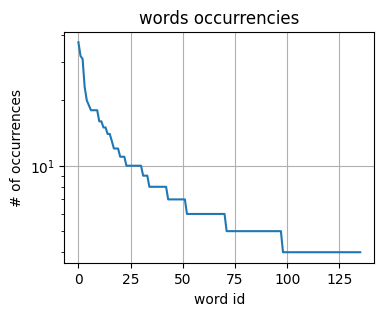

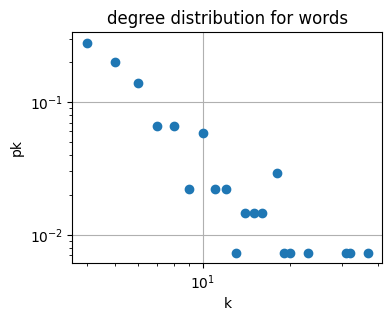

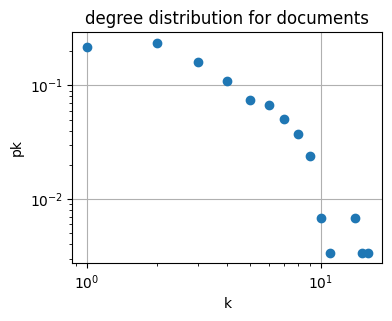

In [14]:
# initialize the class
# use min and max to control which words you are using
td1 = TopicDetection(ct1, n_min=4, n_max=40) # <-- min and max here!
# and build probability matrices first
td1.probability_matrices()
# show words occurrences
td1.plot_word_occurrence()
# show words degree distribution
td1.plot_degree_distributions(quale='words')
# show documents degree distribution
td1.plot_degree_distributions(quale='comments')

In [15]:
word_degrees = td1.Mwd.sum(axis=1)
kmin=np.min(word_degrees)
slope=1+1/np.mean(np.log(word_degrees/kmin))
"This is the slope of the network", slope

('This is the slope of the network', 3.015338295050178)

In [16]:
degrees=word_degrees.flatten()
degrees=np.array(degrees)

array([16,  5,  4,  4,  5,  5,  5,  6,  5,  6,  4,  5,  4,  8, 18,  4,  5,
        4,  4,  6,  5,  5,  8,  4,  9,  4,  4,  5,  4, 20,  4,  8,  4,  7,
        4,  4,  7, 10,  4, 18, 10,  4,  4,  9, 18, 11,  8,  4,  7,  4,  4,
       15,  5, 13,  4,  6,  6,  4,  6,  6, 12,  5,  4, 10,  5,  4,  4,  7,
        4, 12, 12,  4,  5,  7,  8,  5, 23,  5,  4, 16,  5,  5,  6,  6,  8,
        4,  7,  6, 14,  6,  5, 19,  6, 32,  4,  8,  4,  6,  7,  6,  4, 11,
       10, 10,  6,  5,  6,  5,  8,  4,  4,  6,  7,  6, 11,  5, 14,  6,  4,
       10, 15, 10,  5,  4,  5, 10,  4, 18,  5,  9,  8,  5,  7, 37,  5, 31])

Quindi le parole sono 1154, ma nella distribution ne abbiamo meno 46

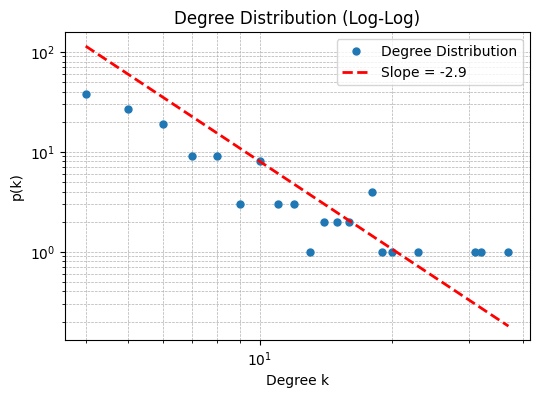

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
# Conta la frequenza di ogni grado
degree_counts = Counter(degrees[0])
k_values = np.array(list(degree_counts.keys()))
p_k = np.array(list(degree_counts.values())) / len(degrees)  # Normalizza

# Ordina per corretto plotting
sorted_indices = np.argsort(k_values)
k_values = k_values[sorted_indices]
p_k = p_k[sorted_indices]

# Grafico log-log
plt.figure(figsize=(6, 4))
plt.loglog(k_values, p_k, 'o', markersize=5, label="Degree Distribution")

# Aggiunta della retta con slope
slope = -2.9
x_fit = np.array(k_values)  # Prende solo i k effettivamente presenti nei dati
y_fit = (p_k[6] * (x_fit / x_fit[6]) ** slope)  # Scala rispetto al primo punto

plt.loglog(x_fit, y_fit, 'r--', linewidth=2, label=f"Slope = {slope}")

# Etichette e titolo
plt.xlabel("Degree k")
plt.ylabel("p(k)")
plt.title("Degree Distribution (Log-Log)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostra il grafico
plt.show()

##TOPIC DETECTION

Louvain topic detection: execution time 0.1662428379058838 [s]


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


{'topics': 16,
 'com': 0.9435049692198103,
 'time': 0.1662428379058838,
 'NMI': 0.7305240815445295,
 'Q': 0.5804632742645177,
 'Ncut': 0.31895203526076715,
 'Infomap': -0.1102166643282032}

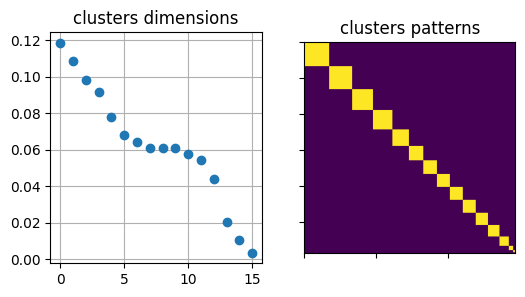

In [19]:
# run louvain clustering - it takes 16 sec for 3K documents
ext = td1.topic_detection_louvain()
# evaluate clustering metrics
td1.clustering_metrics(ext)
# show clusters sizes
td1.display_clusters()
# show statistics
td1.stats

In [20]:
# save topic assignment
df['topic'] = np.nan
topics = np.array(df['topic'])
topics[td1.documents] = td1.topics # not all the documents are assigned to topics!
df['topic'] = topics
df.to_excel("Ian_comments_topics.xlsx")

In [21]:
# save class
td1.pickle_export("Ian_comments.pickle")

In [22]:
# load data
td2 = TopicDetection()
td2.pickle_import("Ian_comments.pickle")

In [23]:
# display keywords from Pwc and BERTopic
active_docs = [ct1.text[i] for i in td2.documents] # not all asiigned to topics
td2.display_keywords(active_docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-02-10 09:42:24,918 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic,#docs,Probability matrices keywords,BERTopic keywords
0,35,God 🙏 pray poor mia ️ ❤ people hope imagine help elderly heart Spain Jesus,god poor my for mia they all please you pray bless mamma help people be
1,32,window 😅 be thing authorization museum destroy work agreement draw difference real other understand look,window the be that there thing no she be on museum agreement have authorization and
2,29,heart 🥺 cry make ' poor 💔 now break people watch go too 🙏 wind,heart my cry poor strong I make with break generation people to not they the
3,27,do moon here second live take want also go able be earth people so weather,do to it be here we not take earth second care the you of all
4,23,still give thank world rain use learn seem school come so forgive see then earth,still our in it give thank be world your where we thy heaven rain learn
5,20,just say good people 👏 weather also know so ask only always look think hurricane,just it people say the say also good its chill tropical uk feel star and
6,19,bathroom tell time then one put Lord too only so go get come lose use,bathroom then the in he time be tell to put one or you twenty tell
7,18,' green get turn global pool bad degree water land weather see always want happen,its turn degree pool global into the and trumpet green in will barren spring bye
8,18,so sad nuclear go 😞 wind solar storm very able 🥰 now be mean still,so sad nuclear wind solar and storm be be very for go will be that
9,18,year happen stop climate hit change go so know watch world think real more make,ha climate be stop this change can every what year happen history we of the


In [24]:
td = TopicDetection(ct1, n_min=3, n_max=40)
td.probability_matrices(equalik=True)
td.topic_detection_louvain()

# Access Pwc (word-topic joint probability)
word_topic_matrix = td.Pwc.toarray()  # Convert sparse matrix to a dense array

# Access the words
words = td.words
words = [word.split()[0] for word in words]

# Extract word frequencies for a specific topic (e.g., topic 0)
topic_id = 0
word_frequencies = word_topic_matrix[:, topic_id]

# Pair words with their frequencies
word_freq_pairs = list(zip(words, word_frequencies))

# Sort by frequency (descending)
word_freq_pairs_sorted = sorted(word_freq_pairs, key=lambda x: x[1], reverse=True)

# Print the top N words for the topic
N = 10
print(f"Top {N} words for topic {topic_id}:")
for word, freq in word_freq_pairs_sorted[:N]:
    print(f"{word}: {freq}")

removing words...
['have VERB' '😭 NOUN']
Occurrence matrix: execution time 0.011080503463745117 [s]
Probability matrices: execution time 0.010219812393188477 [s]
Louvain topic detection: execution time 0.13710308074951172 [s]
Top 10 words for topic 0:
🙏: 0.024123455762943245
God: 0.013535282099638534
pray: 0.007425742574257426
safety: 0.005421970768505422
️: 0.004898774191144604
safe: 0.004871915763004871
keep: 0.004596888260254597
mia: 0.004243281471004243
bless: 0.003771805752003772
Spain: 0.003667033370003667


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [25]:
top_words_per_topic = {}

for topic_id in range(word_topic_matrix.shape[1]):
    word_frequencies = word_topic_matrix[:, topic_id]
    word_freq_pairs = list(zip(words, word_frequencies))
    word_freq_pairs_sorted = sorted(word_freq_pairs, key=lambda x: x[1], reverse=True)
    top_words_per_topic[topic_id] = word_freq_pairs_sorted[:10]  # Top 10 words


Topic 0:
  🙏: 0.024123455762943245
  God: 0.013535282099638534
  pray: 0.007425742574257426
  safety: 0.005421970768505422
  ️: 0.004898774191144604
  safe: 0.004871915763004871
  keep: 0.004596888260254597
  mia: 0.004243281471004243
  bless: 0.003771805752003772
  Spain: 0.003667033370003667
Topic 1:
  heart: 0.01722981821991723
  🥺: 0.0152993870815653
  cry: 0.011257792445911258
  poor: 0.008295353344858293
  ’m: 0.007425742574257425
  make: 0.006417308397506417
  💔: 0.004361150400754361
  people: 0.0038268112525538267
  ❤: 0.0028052805280528053
  now: 0.0026324060977526323
Topic 2:
  window: 0.008510136727958511
  thing: 0.007398239823982398
  museum: 0.004655822725129656
  look: 0.0038503850385038503
  agreement: 0.003634292000628634
  authorization: 0.0036067892503536068
  bad: 0.0033003300330033004
  be: 0.0032806852113782805
  real: 0.003221750746503222
  work: 0.003221750746503222
Topic 3:
  just: 0.013173817381738173
  ️: 0.007920792079207921
  good: 0.00781078107810781
  col

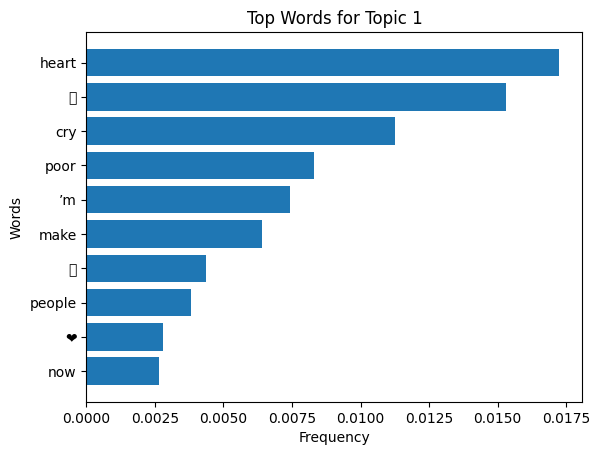

In [44]:
import matplotlib.pyplot as plt

# Plot top words for a specific topic
topic_id = 1
top_words = top_words_per_topic[topic_id][:10]  # Top 10 words for topic 0
words, frequencies = zip(*top_words)

plt.barh(words, frequencies)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title(f"Top Words for Topic {topic_id}")
plt.gca().invert_yaxis()
plt.show()

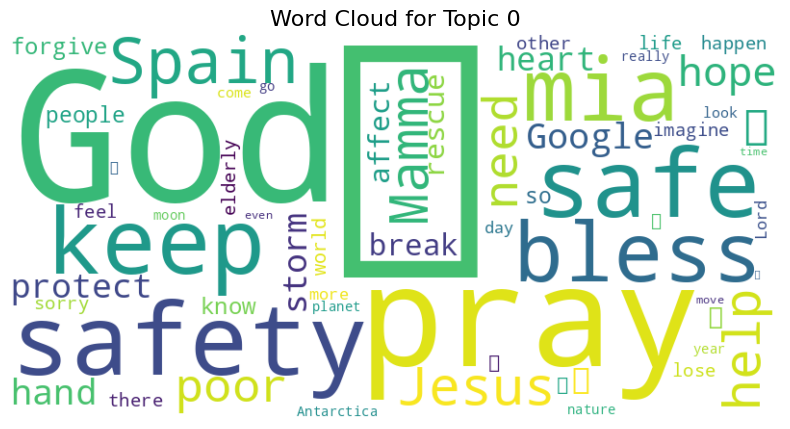

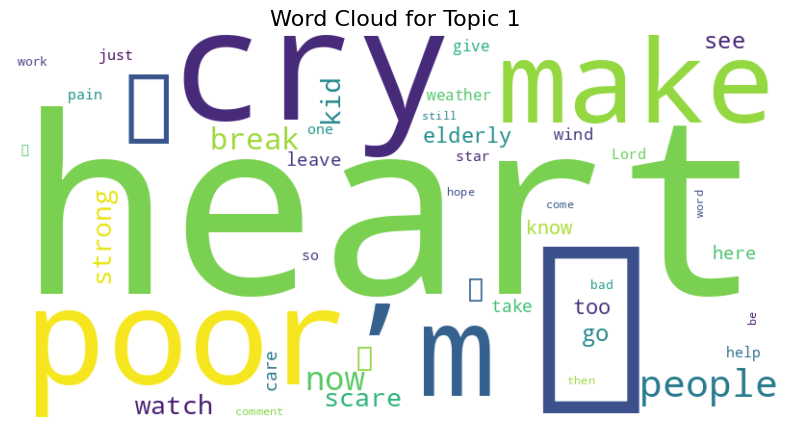

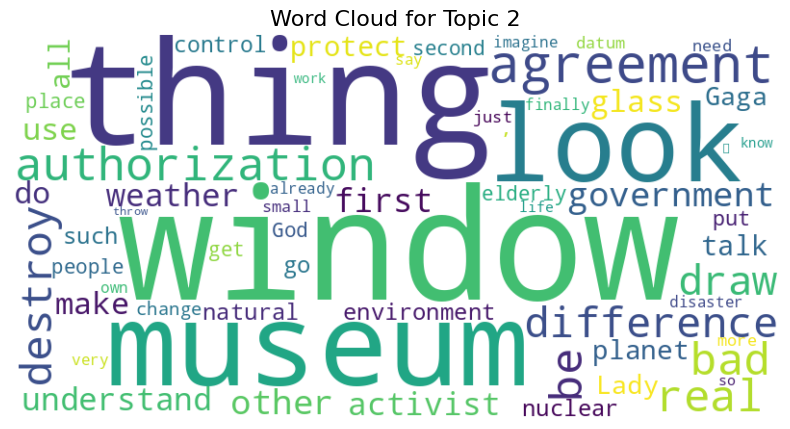

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Find the top 3 largest topics
topic_sizes = td.C.sum(axis=0).A1  # Sum along columns of the C matrix to get topic sizes
top_topics = topic_sizes.argsort()[-3:][::-1]  # Indices of the 3 largest topics

words = td.words
words = [word.split()[0] for word in words]
# Generate word clouds for the top 3 topics
for topic_id in top_topics:
    # Get word frequencies for the current topic
    word_frequencies = td.Pwc[:, topic_id].toarray().flatten()  # Word frequencies for the topic
    word_freq_dict = {
        word: freq
        for word, freq in zip(words, word_frequencies)
    }

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}", fontsize=16)
    plt.show()

In [50]:
t_names = [
    "Faith & Spirituality",
    "Museum",
    "Struggles",
    "Space & Moon",
    "Gratitude",
    "Natural Disasters",
    "Daily Life",
    "Environment",
    "Energy",
    "Climate Change",
    "Travel",
    "Safety",
    "Politics, Government",
    "Hope",
    "Pain, Loss",
    "God, The Universe"
]



In [51]:
for i in range(td2.pc.shape[1]):
  print(f'topic {i}' )

topic 0
topic 1
topic 2
topic 3
topic 4
topic 5
topic 6
topic 7
topic 8
topic 9
topic 10
topic 11
topic 12
topic 13
topic 14
topic 15


CPU times: user 59.8 ms, sys: 10.9 ms, total: 70.6 ms
Wall time: 42.2 ms


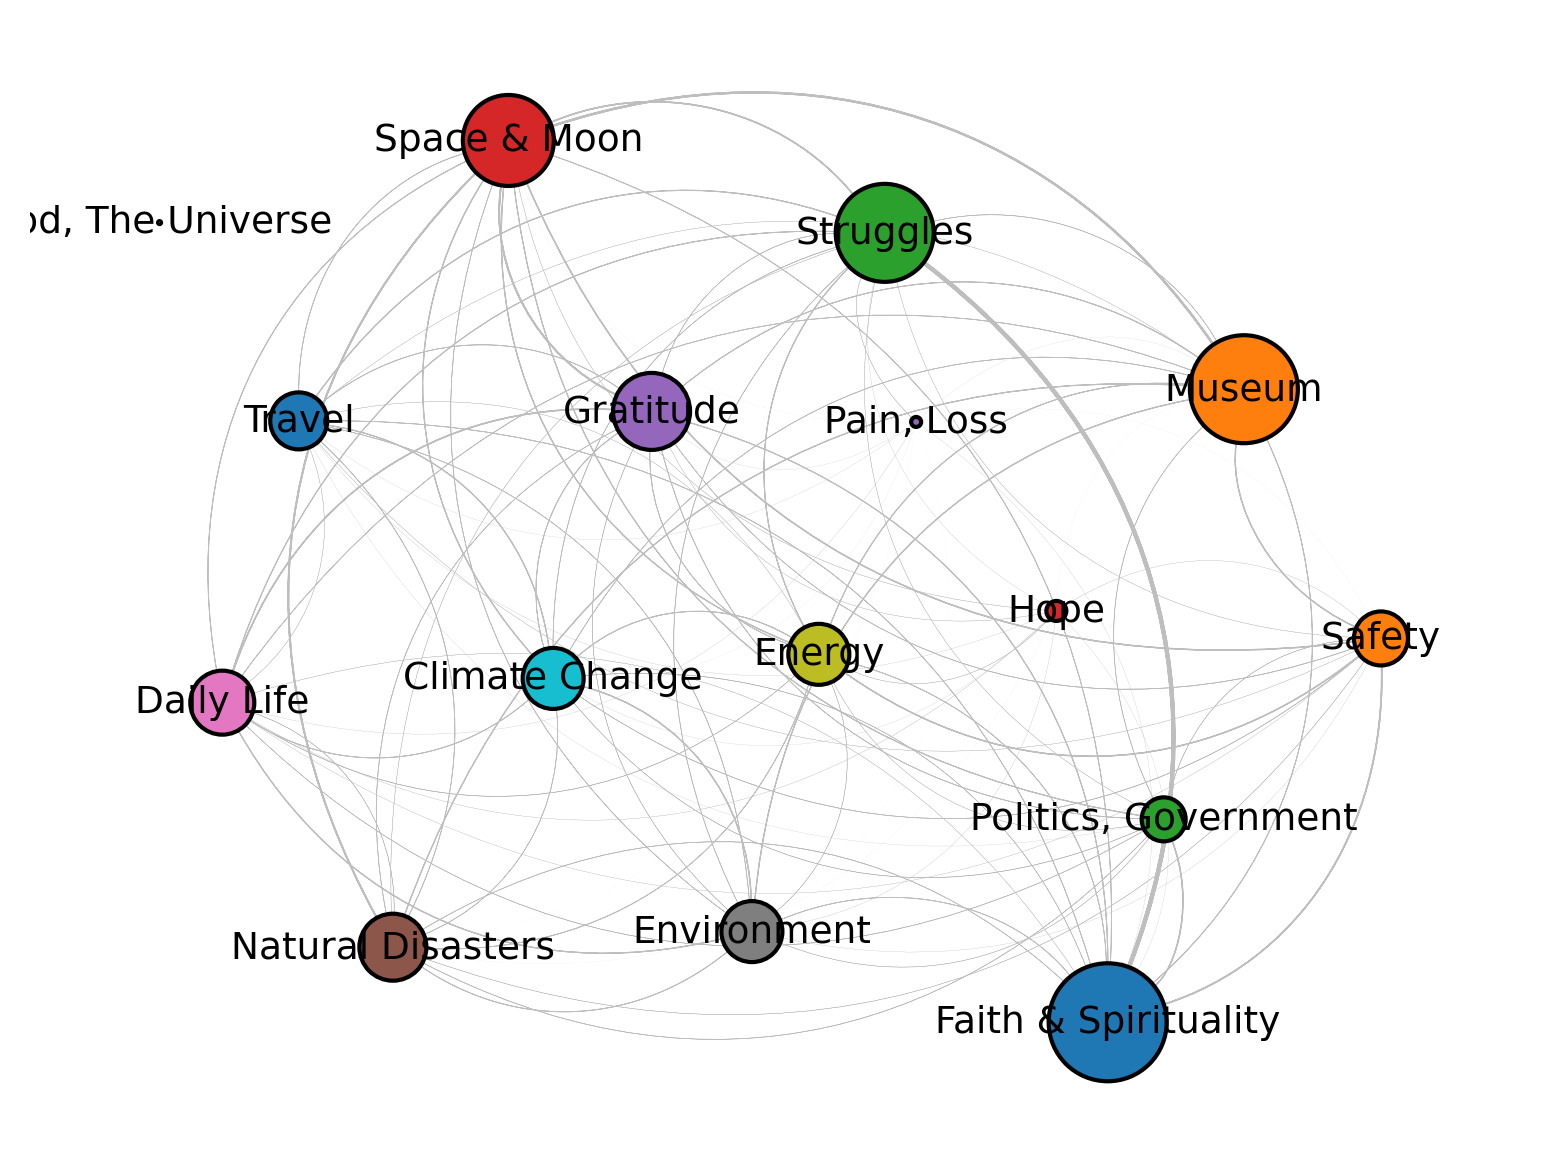

In [52]:
# nodes coordinates by umap: we use communities matrix as adjacency matrix
%time t_pos = umap.UMAP().fit_transform(td2.Pcc.toarray())
t_pos = t_pos-t_pos.mean(0) # we subtract the average values here

# topic centrality by pc
t_cen = np.array(td2.pc)[0]


# topic colors ... hard assignment
t_colors = sns.color_palette("tab10")

# build graph using Pcc
A = td2.Pcc.toarray()
np.fill_diagonal(A, 0)
G = ig.Graph.Adjacency((A>0).tolist())
At = np.tril(A, k=0)
G.es['weight'] = np.array(At[A.nonzero()])

# plot graph
fig, ax = plt.subplots(dpi=300)
ig.plot(G,
        target = ax,
        layout = t_pos,
        vertex_size = 1000*t_cen,
        vertex_color = t_colors,
        vertex_label = t_names,
        vertex_label_size = 9,
        vertex_label_dist = 0,
        edge_width = 100*np.array(G.es["weight"]),
        edge_color = 'gray',
        edge_arrow_size = 0.001
        )